<a href="https://colab.research.google.com/github/Neela1994/Neela1994/blob/main/DA_Project1_Bank_customer_segmentation_Pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Bank Customer Segmentation**

In this project, we will be creating Customer Segmentation using bank customer transaction dataset of an Indian bank.
The Data for this project is obtained from Kaggle, banking transaction's dataset of an Indian bank from August 2016 to October 2016 and has data volume of 1 million transactions and comprising of about 800k customer details We will make use of K-means and Bisecting K-Means clustering techniques which is the essential algorithm for clustering unlabeled datasets.

Connecting Drive to Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Reading Data from Drive

In [2]:
!unzip "/content/drive/MyDrive/bank_transactions.csv (1).zip"

Archive:  /content/drive/MyDrive/bank_transactions.csv (1).zip
  inflating: bank_transactions.csv   


Setting up PySpark in Colab

Spark is written in the Scala programming language and requires the Java Virtual Machine (JVM) to run. Therefore, our first task is to download Java.

we will install Apache Spark 3.0.1 with Hadoop 2.7 and unzip that folder.

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [4]:
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

In [5]:
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

Install Pyspark libraries

In [6]:
!pip install -q findspark

In [7]:
!pip install pyspark
import sql

     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 198 kB 41.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=264c21fa2327e1bdcff76456d4f87f2acba4fbbc6d2f579ea6fc3a9c7ed2ef8e
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


set the environment path. This will enable us to run Pyspark in the Colab environment.

In [8]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [9]:
import findspark
findspark.init()

In [10]:
findspark.find()

'/content/spark-3.2.1-bin-hadoop3.2'

Import SparkSession from pyspark.sql and create a SparkSession, which is the entry point to Spark.

In [11]:
import pyspark 
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Bank Customer Segmentation")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [12]:
sparkContext=spark.sparkContext

print the SparkSession variable.

In [13]:
spark

 Load the dataset. We will use the read.csv module. The inferSchema parameter provided will enable Spark to automatically determine the data type for each column but it has to go over the data once. 

In [14]:
df = spark.read.csv("bank_transactions.csv", header=True, inferSchema=True)

**Understanding the Dataset**

In [ ]:
#df.printSchema()
#df.count()

root
 |-- TransactionID: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- CustomerDOB: string (nullable = true)
 |-- CustGender: string (nullable = true)
 |-- CustLocation: string (nullable = true)
 |-- CustAccountBalance: double (nullable = true)
 |-- TransactionDate: string (nullable = true)
 |-- TransactionTime: integer (nullable = true)
 |-- TransactionAmount (INR): double (nullable = true)





 we can see certain columns have null values. The columns with null values amount to 1 percent of total data, hence dropping the rows with null columns.


In [15]:
from pyspark.sql import functions as F
df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).show()

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|            0|         0|          0|      1100|         151|              2369|              0|              0|                      0|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+



 Transaction ID column has no effect on data analysis, hence dropping the Transaction ID column


In [16]:
#drop column transaction id as it is of no use
df = df.drop(*['TransactionID'])

In [17]:
#df.columns
df.describe().show()

+-------+----------+-----------+----------+--------------------+------------------+---------------+------------------+-----------------------+
|summary|CustomerID|CustomerDOB|CustGender|        CustLocation|CustAccountBalance|TransactionDate|   TransactionTime|TransactionAmount (INR)|
+-------+----------+-----------+----------+--------------------+------------------+---------------+------------------+-----------------------+
|  count|   1048567|    1048567|   1047467|             1048416|           1046198|        1048567|           1048567|                1048567|
|   mean|      null|        NaN|      null|            400012.0|115403.54005622343|           null|157087.52939297154|     1574.3350034571733|
| stddev|      null|        NaN|      null|                 0.0|  846485.380600677|           null| 51261.85402233114|      6574.742978453954|
|    min|  C1010011|     1/1/00|         F|(154) BHASKOLA FA...|               0.0|         1/8/16|                 0|                    0.0|

In [18]:
#Drop rows with empty values for column
df_1=df.dropna()
df_1.show()

+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|
+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|  C5841053|    10/1/94|         F|  JAMSHEDPUR|          17819.05|         2/8/16|         143207|                   25.0|
|  C2142763|     4/4/57|         M|     JHAJJAR|           2270.69|         2/8/16|         141858|                27999.0|
|  C4417068|   26/11/96|         F|      MUMBAI|          17874.44|         2/8/16|         142712|                  459.0|
|  C5342380|    14/9/73|         F|      MUMBAI|         866503.21|         2/8/16|         142714|                 2060.0|
|  C9031234|    24/3/88|         F| NAVI MUMBAI|           6714.43|         2/8/16|         181156|                 1762.5|
|  C1536

In [ ]:
#df_1.count()
#df_1.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).show()

1044947

There are a lot of birth date on 1/1/1800, which seems to be default birth date for customers without date of birth detail, hence removed rows with that value as column


In [19]:
df_2 = df_1.filter((df_1.CustomerDOB != '1/1/1800'))
df_2.count()


988655

In order to calculate the age of each customer, converted the format of columns CustDOB, TransactionDate into standard pyspark date format format.The recorded details were from the year 2016, in order to find the age, firstly calculated maximum transaction date and subtracted from date of birth of each customer

In [20]:
from pyspark.sql.functions import translate
df_upd=df_2.withColumn('CustomerDOB', translate('CustomerDOB', '/', '-'))
df_upd.show(truncate=False)


+----------+-----------+----------+-----------------------+------------------+---------------+---------------+-----------------------+
|CustomerID|CustomerDOB|CustGender|CustLocation           |CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|
+----------+-----------+----------+-----------------------+------------------+---------------+---------------+-----------------------+
|C5841053  |10-1-94    |F         |JAMSHEDPUR             |17819.05          |2/8/16         |143207         |25.0                   |
|C2142763  |4-4-57     |M         |JHAJJAR                |2270.69           |2/8/16         |141858         |27999.0                |
|C4417068  |26-11-96   |F         |MUMBAI                 |17874.44          |2/8/16         |142712         |459.0                  |
|C5342380  |14-9-73    |F         |MUMBAI                 |866503.21         |2/8/16         |142714         |2060.0                 |
|C9031234  |24-3-88    |F         |NAVI MUMBAI         

In [21]:
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [22]:
from pyspark.sql.functions import to_date
 
df_upd= df_upd.withColumn('DOB',to_date(df_upd.CustomerDOB, 'dd-MM-yy'))
df_upd.printSchema()
df_upd.select("DOB").dtypes

root
 |-- CustomerID: string (nullable = true)
 |-- CustomerDOB: string (nullable = true)
 |-- CustGender: string (nullable = true)
 |-- CustLocation: string (nullable = true)
 |-- CustAccountBalance: double (nullable = true)
 |-- TransactionDate: string (nullable = true)
 |-- TransactionTime: integer (nullable = true)
 |-- TransactionAmount (INR): double (nullable = true)
 |-- DOB: date (nullable = true)



[('DOB', 'date')]

In [ ]:
#df_upd.show()

In [23]:
from pyspark.sql.functions import translate
df_upd1=df_upd.withColumn('TransactionDate', translate('TransactionDate', '/', '-'))
df_upd1.show(truncate=False)

+----------+-----------+----------+-----------------------+------------------+---------------+---------------+-----------------------+----------+
|CustomerID|CustomerDOB|CustGender|CustLocation           |CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|DOB       |
+----------+-----------+----------+-----------------------+------------------+---------------+---------------+-----------------------+----------+
|C5841053  |10-1-94    |F         |JAMSHEDPUR             |17819.05          |2-8-16         |143207         |25.0                   |1994-01-10|
|C2142763  |4-4-57     |M         |JHAJJAR                |2270.69           |2-8-16         |141858         |27999.0                |1957-04-04|
|C4417068  |26-11-96   |F         |MUMBAI                 |17874.44          |2-8-16         |142712         |459.0                  |1996-11-26|
|C5342380  |14-9-73    |F         |MUMBAI                 |866503.21         |2-8-16         |142714         |2060.0        

In [24]:
from pyspark.sql.functions import to_date
 
df_upd1= df_upd1.withColumn('Trans_date',to_date(df_upd1.TransactionDate, 'dd-MM-yy'))
df_upd1.printSchema()
df_upd1.select("Trans_date").dtypes

root
 |-- CustomerID: string (nullable = true)
 |-- CustomerDOB: string (nullable = true)
 |-- CustGender: string (nullable = true)
 |-- CustLocation: string (nullable = true)
 |-- CustAccountBalance: double (nullable = true)
 |-- TransactionDate: string (nullable = true)
 |-- TransactionTime: integer (nullable = true)
 |-- TransactionAmount (INR): double (nullable = true)
 |-- DOB: date (nullable = true)
 |-- Trans_date: date (nullable = true)



[('Trans_date', 'date')]

In [25]:
from pyspark.sql import functions as F
max_date = df_upd1.select(F.max(df_upd1['Trans_date'])).collect()[0][0]
df_upd1 = df_upd1.withColumn('Age', F.datediff(F.lit(max_date), df_upd1['DOB'])/365.25)
from pyspark.sql.functions import floor, col
##df_upd2.select("*", floor(col('Age'))).show()
df_upd1 = df_upd1.withColumn('Cust_Age', F.floor(F.col('Age')))
df_upd1.show()



+----------+-----------+----------+--------------------+------------------+---------------+---------------+-----------------------+----------+----------+------------------+--------+
|CustomerID|CustomerDOB|CustGender|        CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|       DOB|Trans_date|               Age|Cust_Age|
+----------+-----------+----------+--------------------+------------------+---------------+---------------+-----------------------+----------+----------+------------------+--------+
|  C5841053|    10-1-94|         F|          JAMSHEDPUR|          17819.05|         2-8-16|         143207|                   25.0|1994-01-10|2016-08-02| 22.77891854893908|      22|
|  C2142763|     4-4-57|         M|             JHAJJAR|           2270.69|         2-8-16|         141858|                27999.0|1957-04-04|2016-08-02|  59.5482546201232|      59|
|  C4417068|   26-11-96|         F|              MUMBAI|          17874.44|         2-8-16

In [26]:
df_upd1=df_upd1.withColumnRenamed("TransactionAmount (INR)","Trans_Amt")
df_upd1.show()

+----------+-----------+----------+--------------------+------------------+---------------+---------------+---------+----------+----------+------------------+--------+
|CustomerID|CustomerDOB|CustGender|        CustLocation|CustAccountBalance|TransactionDate|TransactionTime|Trans_Amt|       DOB|Trans_date|               Age|Cust_Age|
+----------+-----------+----------+--------------------+------------------+---------------+---------------+---------+----------+----------+------------------+--------+
|  C5841053|    10-1-94|         F|          JAMSHEDPUR|          17819.05|         2-8-16|         143207|     25.0|1994-01-10|2016-08-02| 22.77891854893908|      22|
|  C2142763|     4-4-57|         M|             JHAJJAR|           2270.69|         2-8-16|         141858|  27999.0|1957-04-04|2016-08-02|  59.5482546201232|      59|
|  C4417068|   26-11-96|         F|              MUMBAI|          17874.44|         2-8-16|         142712|    459.0|1996-11-26|2016-08-02|19.901437371663246|  

In [27]:
df_fin=df_upd1.filter((df_upd1.Cust_Age > '0'))
df_fin.count()

983347

**Calculating RFM (Recency Frequency Monetary)**

For behavioural segmentation of customers, RFM attributes needed to be calculated.In order to provide more efficient segmentation of customers, age and account balance of customers were also taken into consideration.

In [28]:
#Recency
from pyspark.sql import functions as F
df_fin = df_fin.withColumn('Recent', F.datediff(F.lit(max_date), df_fin['Trans_date']))


In [30]:
df_fin.show()

+----------+-----------+----------+--------------------+------------------+---------------+---------------+---------+----------+----------+------------------+--------+------+
|CustomerID|CustomerDOB|CustGender|        CustLocation|CustAccountBalance|TransactionDate|TransactionTime|Trans_Amt|       DOB|Trans_date|               Age|Cust_Age|Recent|
+----------+-----------+----------+--------------------+------------------+---------------+---------------+---------+----------+----------+------------------+--------+------+
|  C5841053|    10-1-94|         F|          JAMSHEDPUR|          17819.05|         2-8-16|         143207|     25.0|1994-01-10|2016-08-02| 22.77891854893908|      22|    80|
|  C2142763|     4-4-57|         M|             JHAJJAR|           2270.69|         2-8-16|         141858|  27999.0|1957-04-04|2016-08-02|  59.5482546201232|      59|    80|
|  C4417068|   26-11-96|         F|              MUMBAI|          17874.44|         2-8-16|         142712|    459.0|1996-11-

In [29]:
from pyspark.sql.functions import *
recency = df_fin.groupBy('CustomerID').agg(min('Recent').alias('Recency'))
recency.show()

+----------+-------+
|CustomerID|Recency|
+----------+-------+
|  C8732711|      0|
|  C6421261|      0|
|  C2939112|      0|
|  C8741166|      0|
|  C4440931|      0|
|  C8116854|      0|
|  C4029960|      0|
|  C7817677|      0|
|  C4240562|      0|
|  C2221420|      0|
|  C8524541|      0|
|  C5638051|      0|
|  C2331867|      0|
|  C5534211|      0|
|  C4940219|      0|
|  C2230276|      0|
|  C4341556|      0|
|  C7283217|      0|
|  C3825339|      0|
|  C4138928|      0|
+----------+-------+
only showing top 20 rows



In [30]:
Age = df_fin.select('CustomerID',"Cust_Age").distinct()
Age.show()

+----------+--------+
|CustomerID|Cust_Age|
+----------+--------+
|  C1239292|      29|
|  C4327789|      34|
|  C8623668|      35|
|  C2132121|      30|
|  C4311142|      59|
|  C5816277|      26|
|  C8131279|      27|
|  C2426546|      31|
|  C2536260|      33|
|  C6639430|      34|
|  C4017276|      36|
|  C4837990|      25|
|  C8970942|      32|
|  C4435153|      23|
|  C7136845|      41|
|  C7318261|      23|
|  C6733857|      45|
|  C8728166|      24|
|  C4611187|      21|
|  C4039120|      33|
+----------+--------+
only showing top 20 rows



In [31]:
from pyspark.sql.functions import *
frequency = df_fin.groupBy('CustomerID', 'TransactionDate').count()\
                        .groupBy('CustomerID')\
                        .agg(count("*").alias("Frequency"))

In [34]:
frequency.show()

+----------+---------+
|CustomerID|Frequency|
+----------+---------+
|  C1715040|        1|
|  C1863042|        1|
|  C8215829|        1|
|  C2132256|        1|
|  C2930516|        1|
|  C4454278|        1|
|  C8123357|        1|
|  C2911183|        1|
|  C7637618|        2|
|  C3329218|        1|
|  C7017149|        3|
|  C7914281|        1|
|  C5625966|        1|
|  C7515046|        1|
|  C8716463|        1|
|  C1218338|        1|
|  C3966179|        1|
|  C5675265|        1|
|  C4437484|        1|
|  C7829736|        4|
+----------+---------+
only showing top 20 rows



In [32]:
monetary = df_fin.groupBy('CustomerID').agg(round(sum('Trans_Amt'), 2).alias('Monetary'))

In [36]:
monetary.show()

+----------+--------+
|CustomerID|Monetary|
+----------+--------+
|  C8732711|  1423.0|
|  C6421261|  9848.0|
|  C2939112|   497.0|
|  C8741166| 1512.75|
|  C4440931|   200.0|
|  C8116854|   270.0|
|  C4029960|    50.0|
|  C7817677|  4498.0|
|  C4240562|   446.0|
|  C2221420|   618.0|
|  C8524541|   445.0|
|  C5638051|  4361.9|
|  C2331867|  1900.0|
|  C5534211|  166.37|
|  C4940219|   460.0|
|  C2230276|  4157.1|
|  C4341556|   430.0|
|  C7283217|   500.0|
|  C3825339|   330.0|
|  C4138928|    80.0|
+----------+--------+
only showing top 20 rows



In [33]:
Acct_balance = df_fin.groupBy('CustomerID').agg(round(sum('CustAccountBalance'), 2).alias('Acct_balance'))

In [38]:
Acct_balance.show()

+----------+------------+
|CustomerID|Acct_balance|
+----------+------------+
|  C8732711|    82130.58|
|  C6421261|    114656.4|
|  C2939112|     8811.89|
|  C8741166|    77948.53|
|  C4440931|    20910.78|
|  C8116854|   511134.58|
|  C4029960|    26683.46|
|  C7817677|    35146.59|
|  C4240562|     59714.7|
|  C2221420|     5301.42|
|  C8524541|       136.2|
|  C5638051|   382526.28|
|  C2331867|    78001.29|
|  C5534211|    55824.26|
|  C4940219|    22686.03|
|  C2230276|    13913.45|
|  C4341556|      6412.6|
|  C7283217|    40306.62|
|  C3825339|    25273.91|
|  C4138928|    21712.39|
+----------+------------+
only showing top 20 rows



In [34]:
rfm = Age.join(recency,'CustomerID', how = 'inner')\
.join(frequency,'CustomerID', how = 'inner')\
             .join(monetary,'CustomerID', how = 'inner')\
             .join(Acct_balance,'CustomerID', how = 'inner')
rfm.show()

+----------+--------+-------+---------+--------+------------+
|CustomerID|Cust_Age|Recency|Frequency|Monetary|Acct_balance|
+----------+--------+-------+---------+--------+------------+
|  C1010011|      24|     25|        2|  5106.0|   152681.27|
|  C1010011|      33|     25|        2|  5106.0|   152681.27|
|  C1010012|      22|     68|        1|  1499.0|    24204.49|
|  C1010014|      32|     75|        2|  1455.0|    200225.9|
|  C1010014|      24|     75|        2|  1455.0|    200225.9|
|  C1010018|      26|     36|        1|    30.0|      496.18|
|  C1010024|      51|     64|        1|  5000.0|    87058.65|
|  C1010028|      28|     53|        1|   557.0|   296828.37|
|  C1010031|      32|     78|        2|  1864.0|    10400.31|
|  C1010031|      28|     78|        2|  1864.0|    10400.31|
|  C1010035|      24|     55|        2|   750.0|   385297.51|
|  C1010035|      36|     55|        2|   750.0|   385297.51|
|  C1010036|      20|     56|        1|   208.0|   355430.17|
|  C1010

Dropping the customer ID column as the feature is not considered for evaluation.

In [35]:
RFM1_F= rfm.drop(*['CustomerID'])
RFM1_F.show()

+--------+-------+---------+--------+------------+
|Cust_Age|Recency|Frequency|Monetary|Acct_balance|
+--------+-------+---------+--------+------------+
|      24|     25|        2|  5106.0|   152681.27|
|      33|     25|        2|  5106.0|   152681.27|
|      22|     68|        1|  1499.0|    24204.49|
|      32|     75|        2|  1455.0|    200225.9|
|      24|     75|        2|  1455.0|    200225.9|
|      26|     36|        1|    30.0|      496.18|
|      51|     64|        1|  5000.0|    87058.65|
|      28|     53|        1|   557.0|   296828.37|
|      32|     78|        2|  1864.0|    10400.31|
|      28|     78|        2|  1864.0|    10400.31|
|      24|     55|        2|   750.0|   385297.51|
|      36|     55|        2|   750.0|   385297.51|
|      20|     56|        1|   208.0|   355430.17|
|      35|     73|        1| 19680.0|    95859.17|
|      24|     44|        1|   100.0|     1290.76|
|      18|     49|        1|   915.0|    11027.18|
|      23|     41|        3| 16

In [36]:
RFM1_F.describe().show()


+-------+------------------+-----------------+------------------+-----------------+-----------------+
|summary|          Cust_Age|          Recency|         Frequency|         Monetary|     Acct_balance|
+-------+------------------+-----------------+------------------+-----------------+-----------------+
|  count|            974733|           974733|            974733|           974733|           974733|
|   mean|30.774911693766395|54.24509378465692|1.3182902394809655|1925.094506321348|138876.3793704489|
| stddev| 8.512348297544058|15.21532046568115|0.5742486425327367| 7012.77732596047|852674.5584044547|
|    min|                 1|                0|                 1|              0.0|              0.0|
|    max|                74|               81|                 6|       1560034.99|   1.1520674626E8|
+-------+------------------+-----------------+------------------+-----------------+-----------------+



**Exploratory Data Analysis**

For Exploratory Data Analysis python data visualization libraries were used. In order to plot graph and charts more efficiently in colab, Pyspark dataframe is converted to pandas dataframe using Topandas() method. This action will collects data from all Pyspark clusters and converts them to pandas dataframe. 
Matplotlib and seaborn libraries were used for data analysis to understand key insights from the dataset for modelling. Below are the inferences made from analysis that can help bank to predict best action for each group:


In [37]:
pdf = rfm.toPandas()


In [46]:
pdf.describe()

,Cust_Age,Recency,Frequency,Monetary,Acct_balance
count,974733.000000,974733.000000,974733.000000,9.747330e+05,9.747330e+05
mean,30.774912,54.245094,1.318290,1.925095e+03,1.388764e+05
std,8.512348,15.215320,0.574249,7.012777e+03,8.526746e+05
min,1.000000,0.000000,1.000000,0.000000e+00,0.000000e+00
25%,25.000000,42.000000,1.000000,2.070000e+02,6.971520e+03
50%,29.000000,53.000000,1.000000,6.000000e+02,2.412016e+04
75%,34.000000,67.000000,2.000000,1.648010e+03,8.140571e+04
max,74.000000,81.000000,6.000000,1.560035e+06,1.152067e+08


In [44]:
#average Age distribution

import matplotlib.pyplot as plt
import seaborn as sns


Understanding correlation between features of the Dataset

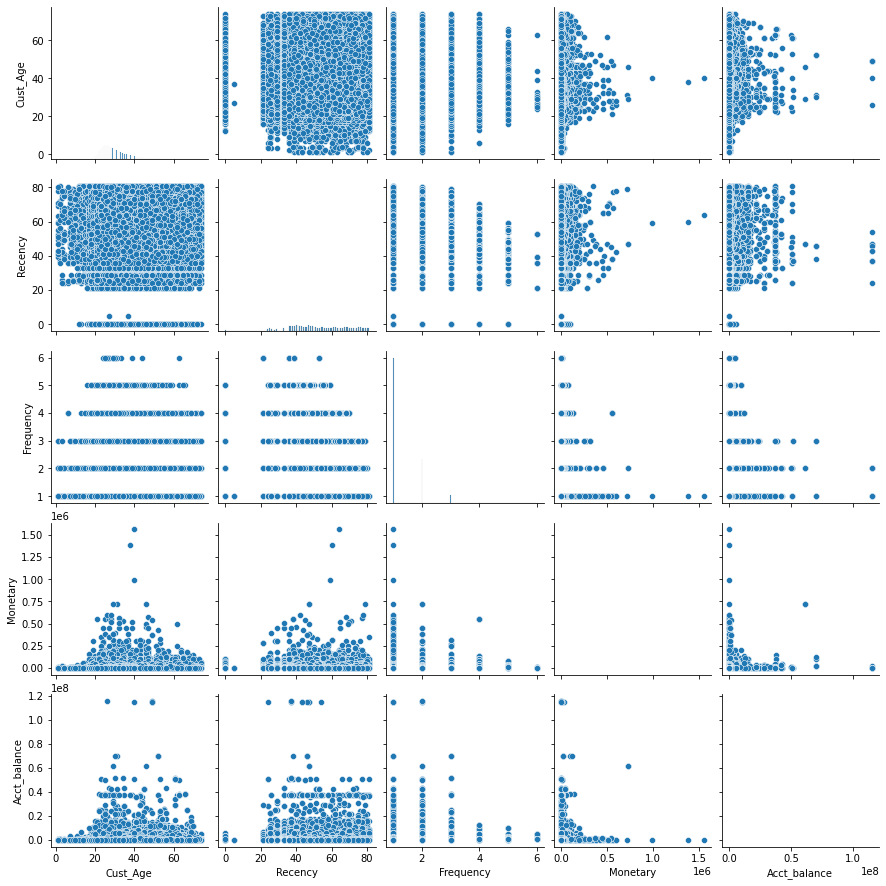

In [56]:
sns.pairplot(pdf)
plt.show()

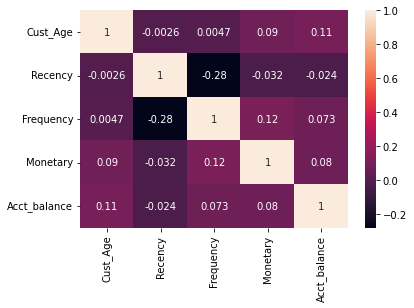

In [41]:
corrMatrix = pdf.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

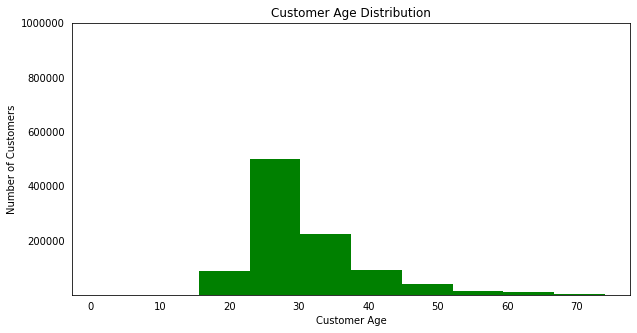

In [45]:
plt.figure(figsize=(10,5))
plt.title("Customer Age Distribution")
plt.xlabel("Customer Age")
plt.ylabel("Number of Customers")
#plt.hist(pdf.Cust_Age[pdf.Cust_Age>0],bins=10,color="green")
plt.hist(pdf.Cust_Age,bins=10,color="green")
plt.ylim(1000, 1000000)
#plt.xlim(0, 100)
plt.tick_params(bottom=False,left=False)
plt.ticklabel_format(style='plain')
plt.show()



Inference : we can clearly see that majority of customers of the bank were in the age range of 25 to 30, followed by age range of 30 to 35.

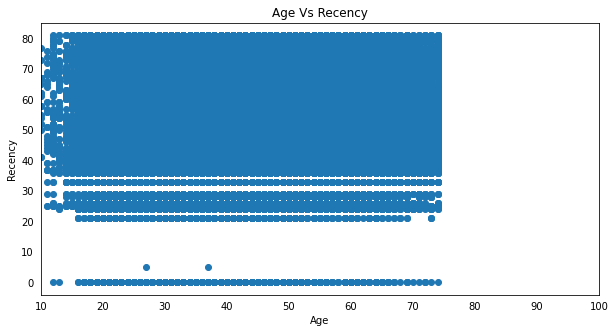

In [54]:
plt.figure(figsize=(10,5))
plt.title("Age Vs Recency")
plt.xlabel("Age")
plt.ylabel("Recency")
plt.scatter(pdf.Cust_Age,pdf.Recency)
#plt.xlim(10, 80)
plt.xlim(10, 100)

plt.tick_params(bottom=False,left=False)
plt.ticklabel_format(style='plain')
plt.show()

Inference: customers at all age group has made recent transactions, it is clearly not enough to segment the customers based on their age

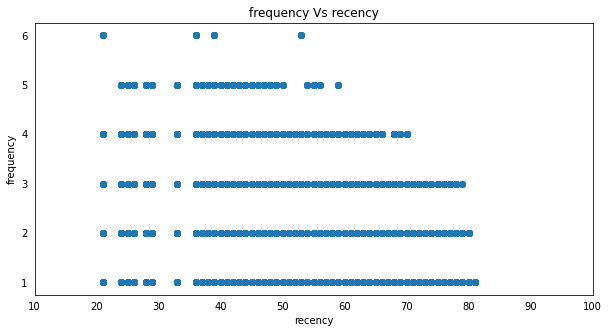

In [52]:
plt.figure(figsize=(10,5))
plt.title("frequency Vs recency")
plt.xlabel("recency")
plt.ylabel("frequency")
plt.scatter(pdf.Recency,pdf.Frequency)
#plt.xlim(10, 80)
plt.xlim(10, 100)

plt.tick_params(bottom=False,left=False)
plt.ticklabel_format(style='plain')
plt.show()

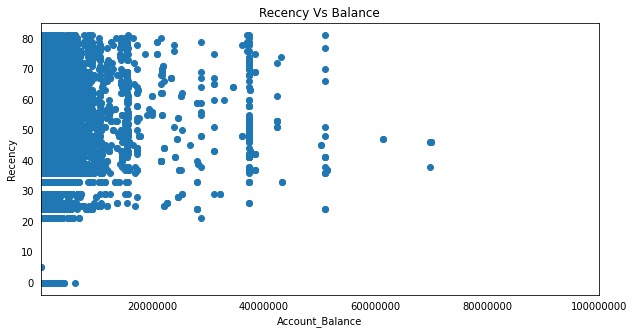

In [49]:
plt.figure(figsize=(10,5))
plt.title("Recency Vs Balance")
plt.xlabel("Account_Balance")
plt.ylabel("Recency")
plt.scatter(pdf.Acct_balance,pdf.Recency)
#plt.xlim(10, 80)
plt.xlim(10000, 100000000)

plt.tick_params(bottom=False,left=False)
plt.ticklabel_format(style='plain')
plt.show()

From above plots we can clearly see there are no unique characteristics of each customer, hence comparing the recency with bank balance to identify potential customer.  we can infer that account balances dominate in the region of 2 crore and customers in that region done more than 3 recent transactions showing that majority of the population were moderately rich.

**Data Modelling and Interpretation**

From EDA, we have made inferences to find important features from the dataset. The next step of the data pipeline is to Model the data for interpretation.
Spark ML libraries were used for data modelling.

In order to enable the machine learning model to be more productive, Feature vectorization is essential which will convert all features into a single multi dimensional array of features, which will be used by machine learning models to interpret data and provide better predictive analytics. Vectorassembler() Spark transformer technique has been used in this project

Standardscaler() is used to resize the distribution of values, normalize the features value in the range of mean of observed values as 0 and the standard deviation as 1.

In [38]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [39]:
vec_assembler = VectorAssembler(inputCols = RFM1_F.columns, outputCol='features')

In [40]:
final_data = vec_assembler.transform(RFM1_F)

In [41]:
final_data.show()

+--------+-------+---------+--------+------------+--------------------+
|Cust_Age|Recency|Frequency|Monetary|Acct_balance|            features|
+--------+-------+---------+--------+------------+--------------------+
|      24|     25|        2|  5106.0|   152681.27|[24.0,25.0,2.0,51...|
|      33|     25|        2|  5106.0|   152681.27|[33.0,25.0,2.0,51...|
|      22|     68|        1|  1499.0|    24204.49|[22.0,68.0,1.0,14...|
|      32|     75|        2|  1455.0|    200225.9|[32.0,75.0,2.0,14...|
|      24|     75|        2|  1455.0|    200225.9|[24.0,75.0,2.0,14...|
|      26|     36|        1|    30.0|      496.18|[26.0,36.0,1.0,30...|
|      51|     64|        1|  5000.0|    87058.65|[51.0,64.0,1.0,50...|
|      28|     53|        1|   557.0|   296828.37|[28.0,53.0,1.0,55...|
|      32|     78|        2|  1864.0|    10400.31|[32.0,78.0,2.0,18...|
|      28|     78|        2|  1864.0|    10400.31|[28.0,78.0,2.0,18...|
|      24|     55|        2|   750.0|   385297.51|[24.0,55.0,2.0

In [42]:
from pyspark.ml.feature import StandardScaler

In [43]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [44]:
scalerModel = scaler.fit(final_data)

In [45]:
final_data = scalerModel.transform(final_data)

In [46]:
final_data.show()

+--------+-------+---------+--------+------------+--------------------+--------------------+
|Cust_Age|Recency|Frequency|Monetary|Acct_balance|            features|      scaledFeatures|
+--------+-------+---------+--------+------------+--------------------+--------------------+
|      24|     25|        2|  5106.0|   152681.27|[24.0,25.0,2.0,51...|[2.81943350543167...|
|      33|     25|        2|  5106.0|   152681.27|[33.0,25.0,2.0,51...|[3.87672106996855...|
|      22|     68|        1|  1499.0|    24204.49|[22.0,68.0,1.0,14...|[2.58448071331236...|
|      32|     75|        2|  1455.0|    200225.9|[32.0,75.0,2.0,14...|[3.75924467390890...|
|      24|     75|        2|  1455.0|    200225.9|[24.0,75.0,2.0,14...|[2.81943350543167...|
|      26|     36|        1|    30.0|      496.18|[26.0,36.0,1.0,30...|[3.05438629755098...|
|      51|     64|        1|  5000.0|    87058.65|[51.0,64.0,1.0,50...|[5.99129619904231...|
|      28|     53|        1|   557.0|   296828.37|[28.0,53.0,1.0,55...

#Elbow method

To determine optimal number of clusters to be formed by K-means and Bisecting K-means, Elbow method is used to determine the k value. Optimal value can be found from the graph generated which looks like a elbow, the point where the elbow is formed is considered as a optimal K value.

Unsupervised machine learning models were validated based on Silhouette Score. Silhoutte score calculates distance between centroids of each cluster, normally value will be between -1 to 1, where -1 represents poor clustering and values closer to 1 indiactes the model is properly clustered for the given data set.

In [47]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

In [48]:
cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(final_data)
    cost[k] = model.summary.trainingCost

# Finding Optimal K value using Elbow method

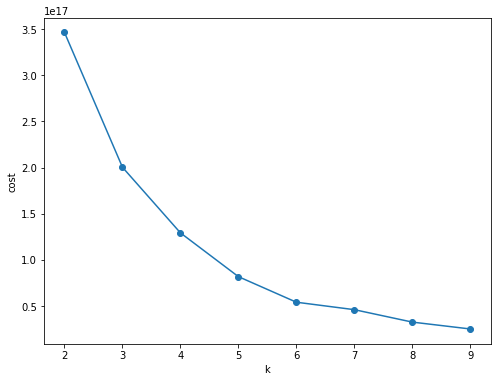

In [50]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),cost[2:10], marker = "o")
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

We can see that elbow is formed at two points. From EDA, we have categorized customers into 3 types, hence number of clusters to use in machine learning algorithms were k=3

**Training the Model and Evaluate**

K-Means Clustering

In [51]:
k = 3
kmeans = KMeans().setK(k).setSeed(1)
model = kmeans.fit(final_data)
# Make predictions
predictions = model.transform(final_data)
predictions.show(5,False)

+--------+-------+---------+--------+------------+--------------------------------+------------------------------------------------------------------------------------------------+----------+
|Cust_Age|Recency|Frequency|Monetary|Acct_balance|features                        |scaledFeatures                                                                                  |prediction|
+--------+-------+---------+--------+------------+--------------------------------+------------------------------------------------------------------------------------------------+----------+
|24      |25     |2        |5106.0  |152681.27   |[24.0,25.0,2.0,5106.0,152681.27]|[2.8194335054316757,1.6430807393368825,3.482811889948846,0.7280995478208171,0.17906159917061912]|0         |
|33      |25     |2        |5106.0  |152681.27   |[33.0,25.0,2.0,5106.0,152681.27]|[3.876721069968554,1.6430807393368825,3.482811889948846,0.7280995478208171,0.17906159917061912] |0         |
|22      |68     |1        |1499.0  |242

In [56]:
# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[3.07253398e+01 5.42592974e+01 1.31652252e+00 1.89609032e+03
 1.01423536e+05]
[4.85522388e+01 5.03034826e+01 1.60199005e+00 1.54454378e+04
 4.22074219e+07]
[3.94764510e+01 5.17088138e+01 1.64197772e+00 6.88849295e+03
 5.58181529e+06]


In [59]:
bla = [e.tolist() for e in centers]
CF = sparkContext.parallelize((bla)).toDF(['Cust_Age', 'Recency', 'Frequency', 'Monetary', 'Acct_balance'])
CF.show()

+------------------+------------------+------------------+------------------+-------------------+
|          Cust_Age|           Recency|         Frequency|          Monetary|       Acct_balance|
+------------------+------------------+------------------+------------------+-------------------+
|30.725339792204792|54.259297350157205|1.3165225249015902|  1896.09031829485| 101423.53570552643|
| 48.55223880597015| 50.30348258706468|1.6019900497512438|15445.437810945272|4.220742187741292E7|
| 39.47645104553449| 51.70881375806136|1.6419777213210864| 6888.492950947828|  5581815.287690083|
+------------------+------------------+------------------+------------------+-------------------+



In [57]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.9920135070352577


In [61]:
summary=predictions.groupBy("prediction").count().show()

+----------+------+
|prediction| count|
+----------+------+
|         1|   190|
|         2|  4348|
|         0|970195|
+----------+------+



**BisectingKMeans**


Bisecting K means

In [66]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator


# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(3).setSeed(1)
modelbkm = bkm.fit(final_data)



In [67]:
# Make predictions
predictions_bkm = modelbkm.transform(final_data)
predictions_bkm.show(5,False)

+--------+-------+---------+--------+------------+--------------------------------+------------------------------------------------------------------------------------------------+----------+
|Cust_Age|Recency|Frequency|Monetary|Acct_balance|features                        |scaledFeatures                                                                                  |prediction|
+--------+-------+---------+--------+------------+--------------------------------+------------------------------------------------------------------------------------------------+----------+
|24      |25     |2        |5106.0  |152681.27   |[24.0,25.0,2.0,5106.0,152681.27]|[2.8194335054316757,1.6430807393368825,3.482811889948846,0.7280995478208171,0.17906159917061912]|0         |
|33      |25     |2        |5106.0  |152681.27   |[33.0,25.0,2.0,5106.0,152681.27]|[3.876721069968554,1.6430807393368825,3.482811889948846,0.7280995478208171,0.17906159917061912] |0         |
|22      |68     |1        |1499.0  |242

In [69]:
# Shows the result.
print("Cluster Centers: ")
centers = modelbkm.clusterCenters()
for center in centers:
    print(center)

Cluster Centers: 
[3.07084845e+01 5.42667199e+01 1.31575073e+00 1.88680860e+03
 9.60292536e+04]
[3.89864751e+01 5.13475627e+01 1.64990138e+00 6.61884380e+03
 4.20378537e+06]
[4.40825893e+01 5.34642857e+01 1.54687500e+00 1.02139223e+04
 2.82381152e+07]


In [68]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions_bkm)
print("Silhouette with squared euclidean distance = " + str(silhouette))


Silhouette with squared euclidean distance = 0.9890936216836177


In [97]:
summary=predictions_bkm.groupBy("prediction").count().show()

+----------+------+
|prediction| count|
+----------+------+
|         1|  7095|
|         2|   448|
|         0|967191|
+----------+------+



Insights with 3 Clusters

In [59]:
pred = predictions.toPandas()

In [60]:
pred.describe()

,Cust_Age,Recency,Frequency,Monetary,Acct_balance,prediction
count,974733.000000,974733.000000,974733.000000,9.747330e+05,9.747330e+05,974733.000000
mean,30.774912,54.245094,1.318290,1.925095e+03,1.388764e+05,0.009116
std,8.512348,15.215320,0.574249,7.012777e+03,8.526746e+05,0.133995
min,1.000000,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000
25%,25.000000,42.000000,1.000000,2.070000e+02,6.971520e+03,0.000000
50%,29.000000,53.000000,1.000000,6.000000e+02,2.412016e+04,0.000000
75%,34.000000,67.000000,2.000000,1.648010e+03,8.140571e+04,0.000000
max,74.000000,81.000000,6.000000,1.560035e+06,1.152067e+08,2.000000


In [53]:
Avg_Pred_p1=predictions.groupBy("prediction").agg({'Cust_Age':'avg', 'Recency':'avg', 'Frequency':'avg','Monetary':'avg','Acct_balance':'avg'})
Avg_Pred_p1.show()

+----------+------------------+------------------+-------------------+------------------+------------------+
|prediction|     avg(Cust_Age)|      avg(Recency)|  avg(Acct_balance)|     avg(Monetary)|    avg(Frequency)|
+----------+------------------+------------------+-------------------+------------------+------------------+
|         1| 49.11052631578947| 50.46842105263158|4.324239642184209E7|16224.468789473684|1.5736842105263158|
|         2| 39.08854645814167|51.740110395584175|  6095344.474993138| 6646.995630174787|1.6492640294388226|
|         0|30.734062739964646| 54.25705966326357| 103740.77045899951|1901.1326149486642| 1.316756940615031|
+----------+------------------+------------------+-------------------+------------------+------------------+



**Prediction Results for all dataset features**

In [54]:
Pandasdf=Avg_Pred_p1.toPandas()

<Figure size 576x360 with 0 Axes>

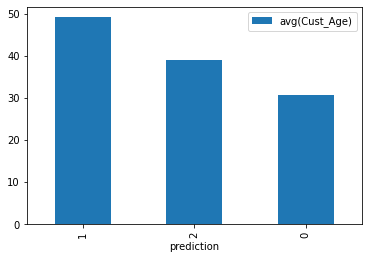

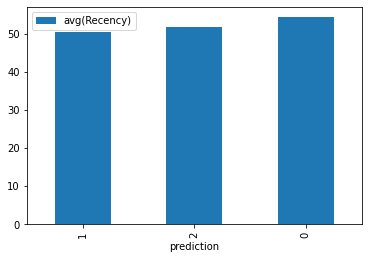

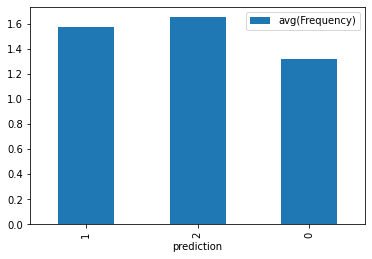

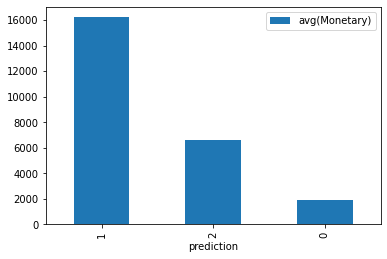

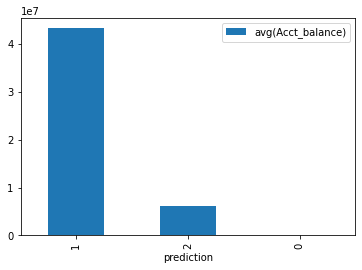

In [56]:
plt.figure(figsize=(8,5))
import matplotlib.pyplot as plt 
#c = ['Blue', 'yellow', 'pink']color = c,
#l=['1','2','0']
p1=Pandasdf.plot(x="prediction", y="avg(Cust_Age)", kind='bar')
#plt.legend((p1[0], p1[1]), ('Men', 'Women')) 
Pandasdf.plot(x="prediction", y="avg(Recency)", kind='bar') 
Pandasdf.plot(x="prediction", y="avg(Frequency)", kind='bar') 
Pandasdf.plot(x="prediction", y="avg(Monetary)",kind='bar') 
Pandasdf.plot(x="prediction", y="avg(Acct_balance)", kind='bar') 
plt.show()

summary of Insights from 3 groups:

*Group 1, Group 2 and Group 3 were behaving similar in terms of recency, frequency.

*Group 1 is considered to be most valuable group as customers in that group maintaining high bank balance with high monetary transaction.

*Group 2 is considered to be valuable customers with moderately high bank balance and with moderate monetary transaction but very less compared to that of group 1.

*Majority of customers belong to group 0 with less bank balance and with less monetary transaction when compared to other two groups.






Conclusion:

This technical project analyzed existing bank customers transactional data of an Indian bank. By using unsupervised machine learning techniques, predicted existing groups of customer and provided strategies that the bank can implement to improve their business.

The performance of clustering models were evaluated using Silhoutte score. Based on the score K-means method outperformed Bisecting K-Means.

For Future works clustering can be performed based on Demographic information and segment customers using different machine learning clustering methods.